# Word2Vec Algorithm

This is an implementation of the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. 
I'm adapting code from a course in Udacity to our problem. The original code is here: https://github.com/udacity/deep-learning-v2-pytorch/tree/master/word2vec-embeddings 

In [1]:
from project_helper import TweetData
from skipgram import get_batches, SkipGramNeg, NegativeSamplingLoss, subsampling
from skipgram import cosine_similarity, cosine_similarity_sample
import numpy as np
import random

import torch
from torch import nn
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
data = TweetData('data/opt/trump_archive_db_1901.csv')

In [3]:
# get list of words
words = data.words
print(words[:30])

['i', 'would', 'suggest', 'you', 'read', 'the', 'complete', 'testimony', 'from', 'tuesday', 'a', 'false', 'narrative', 'is', 'so', 'bad', 'for', 'our', 'country', 'i', 'value', 'our', 'intelligence', 'community', 'happily', 'we', 'had', 'a', 'very', 'good']


In [4]:
print("Total words in Trump's tweets: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in Trump's tweets: 294312
Unique words: 3898


In [5]:
# These are two dictionaries to convert words to integers and back again (integers to words). 
# The integers are assigned in descending frequency order, so the most frequent word ("the") 
# is given the integer 0 and the next most frequent is 1, etc. 

vocab_to_int, int_to_vocab = data.vocab_to_int, data.int_to_vocab
int_words = data.int_words

print(int_words[:30])

[8, 78, 2961, 11, 448, 0, 514, 1838, 41, 565, 3, 504, 2215, 6, 36, 98, 7, 18, 51, 8, 2216, 18, 704, 1232, 2962, 19, 112, 3, 38, 89]


## Training


In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Get our noise distribution
threshold = 1e-4 #lowered threshold as used in Word2Vec algorithm since we have smaller sample
freqs, train_words = subsampling(threshold, int_words)
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

#original is 5, skipgram paper suggests up to 20 for small data sets
N_negative_sampling = 7

# instantiating the model
embedding_dim = 100
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using Negative Sampling Loss as our loss function
criterion = NegativeSamplingLoss() 

# Choosing optimzier
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train for some number of epochs
print_every = 200
steps = 0
epochs = 20


for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], N_negative_sampling)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/20
Loss:  8.127631187438965
trump | fighting, frank, ag, stopping, words
out | salvador, yours, times, sgt, education
do | developing, sony, puppet, voters, hole
for | competitive, additional, dummy, focus, live
should | successful, honored, made, practice, kingdom
it | network, create, coach, shut, commander
thank | garden, s, accountability, which, south
not | kind, legendary, special, by, her
manufacturing | one, those, letters, virginia, doctor
mexican | negotiations, largest, little, week, clearly
short | words, bible, cuts, barbara, comments
atlantic | knowledge, response, africa, denuclearization, upset
opponent | picks, rex, complaining, speak, isnt
woman | focused, grateful, non, mean, return
leave | anytime, seat, flip, vicious, opening
barriers | read, having, park, weak, pittsburgh
...

Epoch: 2/20
Loss:  4.717779636383057
when | shown, here, poll, jobs, bankrupt
i | as, jobs, senate, and, flunky
been | unacceptable, dress, meeting, poor, intel
going | of, kim, did

changed | regulations, times, wouldnt, dishonest, quick
...

Epoch: 12/20
Loss:  2.7372584342956543
s | getting, u, many, suites, are
but | much, run, up, is, looking
them | up, with, come, restaurant, close
what | do, not, robert, entrepreneurs, sense
make | america, great, ohio, join, florida
being | fast, will, for, we, back
been | by, leading, time, poor, dr
clinton | hillary, crooked, why, because, mail
council | thrown, shooting, briefed, incompetent, kudlow
failure | new, fatal, become, desperately, won
anybody | almost, know, enough, whether, ocare
trillion | trade, days, haspel, contract, help
mexican | game, largest, negotiations, very, companies
pence | director, announcement, dirty, africa, waste
gang | pray, rosie, forced, are, criminals
secure | our, government, dems, southern, security
...

Epoch: 13/20
Loss:  2.703456401824951
very | canada, clintons, makes, am, post
of | the, when, all, toward, thousands
want | up, with, negotiations, democrats, sadly
just | because, o

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.
Wiki on T-SNE, a bit complicated! https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [7]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

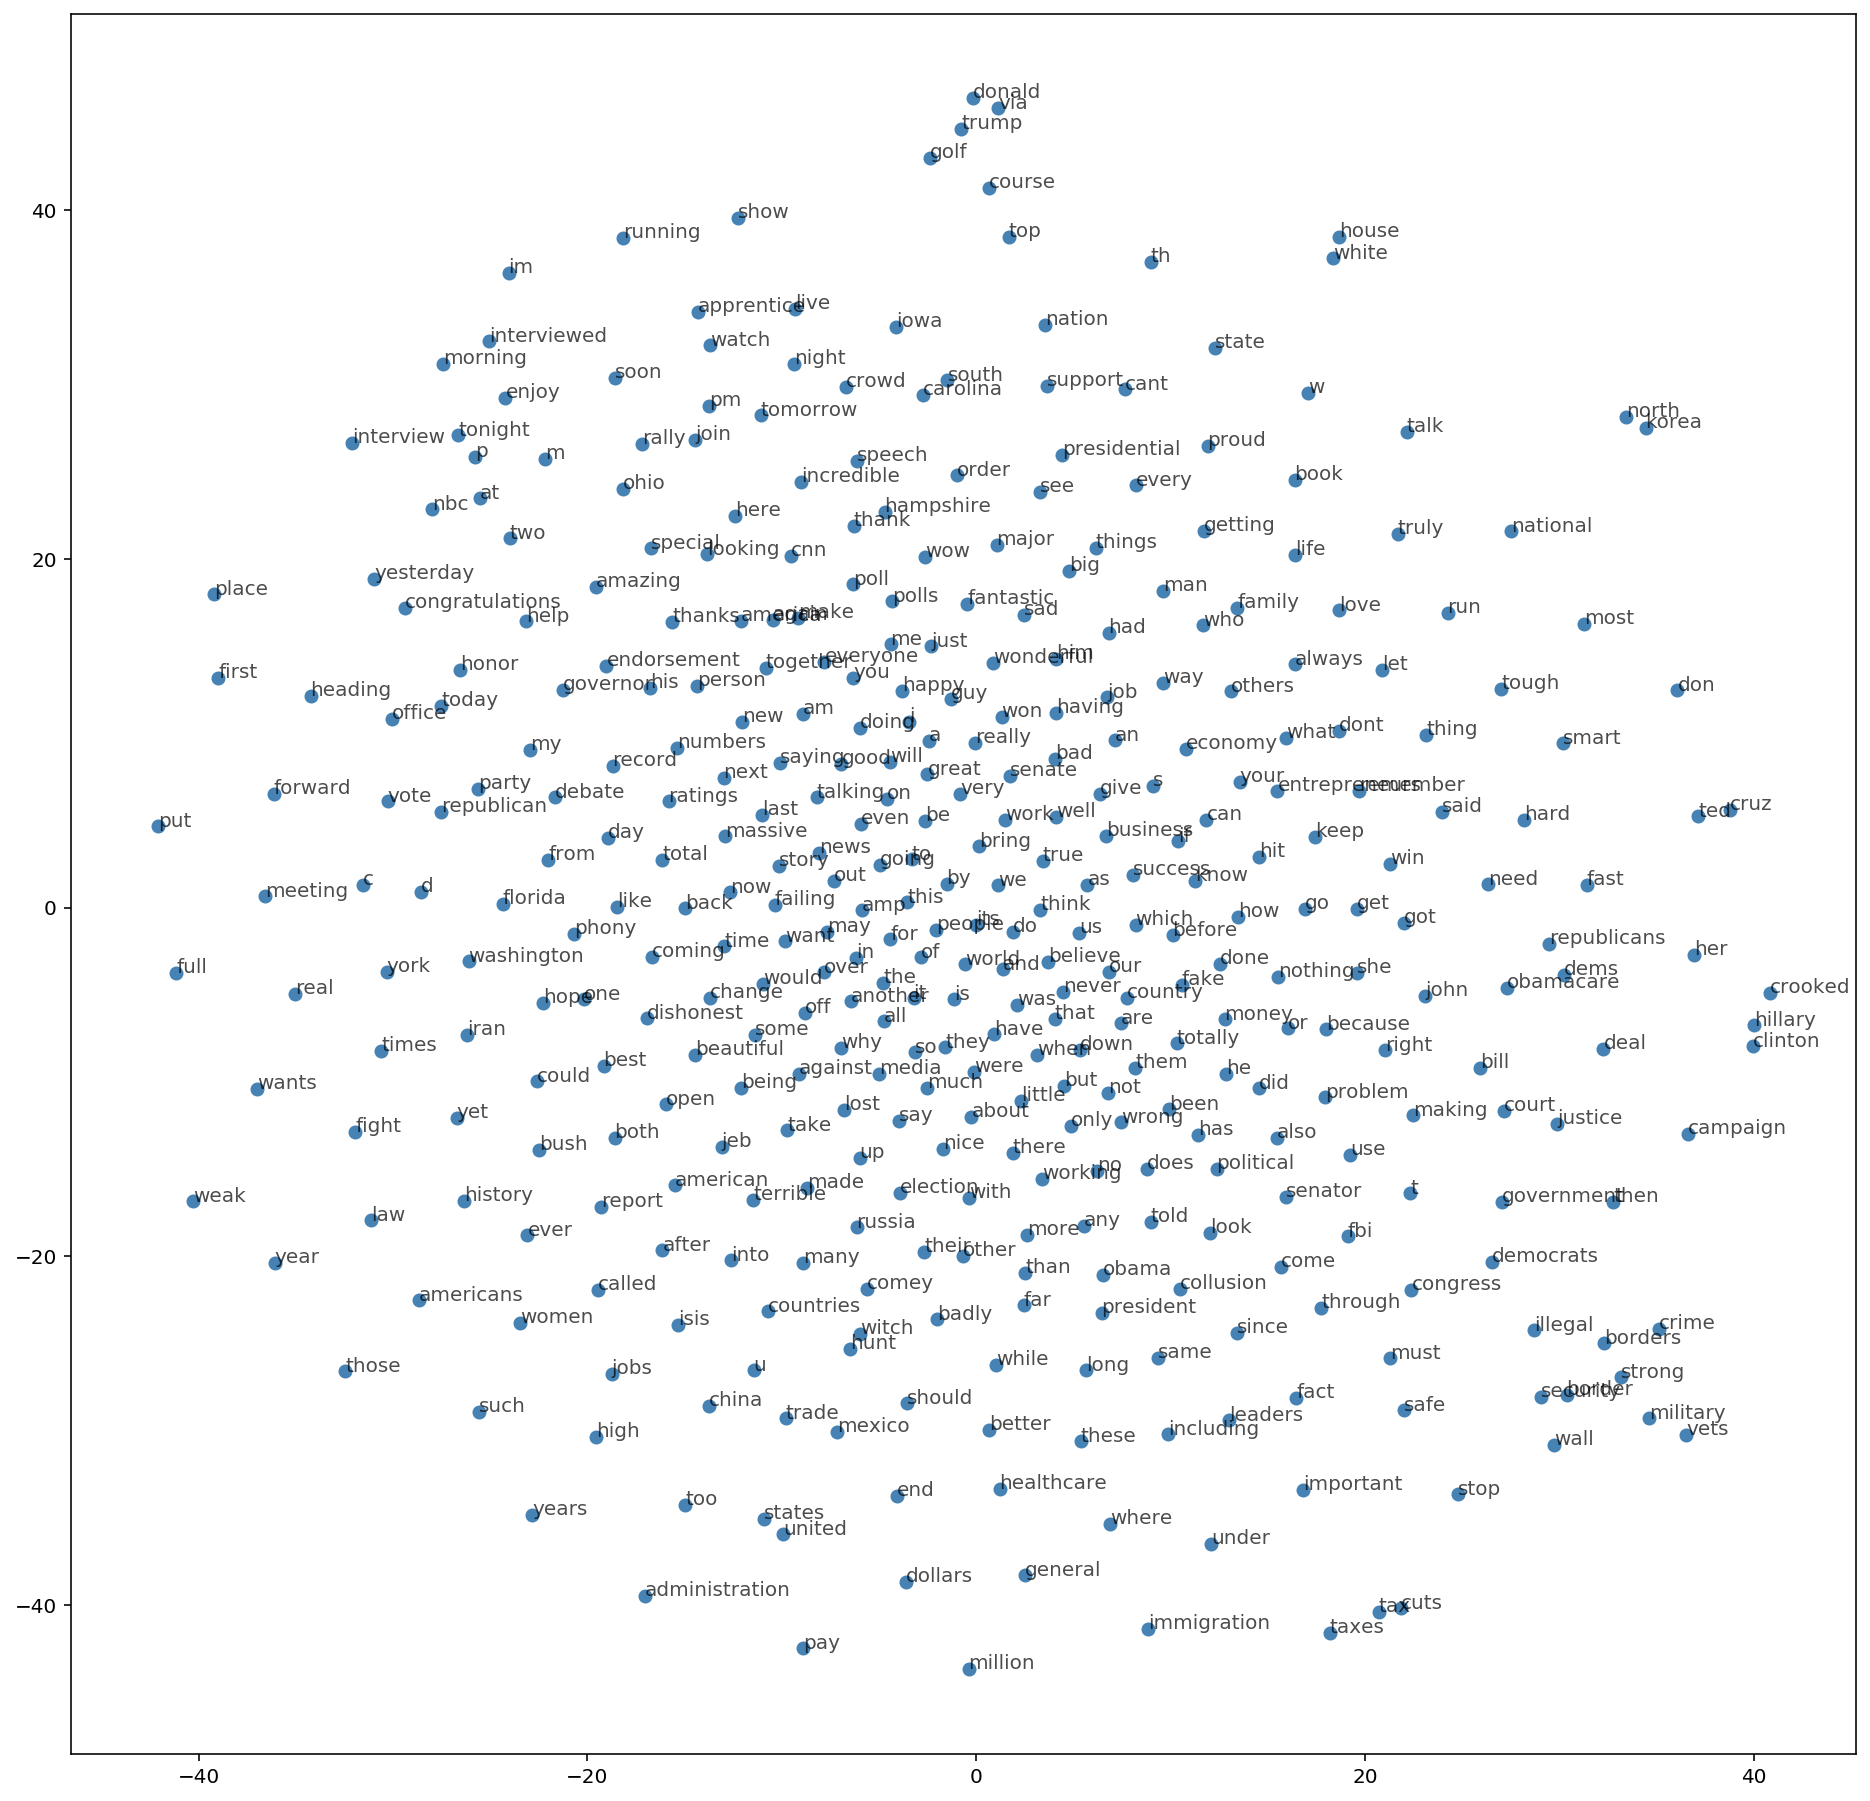

In [8]:
viz_words = 400
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [9]:
def word_similarities(word, num):
    word_int = vocab_to_int[word]
    valid_examples, valid_similarities = cosine_similarity_sample(model.in_embed, [word_int])
    closest_idxs = valid_similarities.topk(num)
    closest_words = [int_to_vocab[int(a)] for a in closest_idxs.indices[0]]
    return closest_words

In [10]:
word_similarities('fed',20)

['fed',
 'off',
 'crossing',
 'longer',
 'briefing',
 'getting',
 'unfairly',
 'entering',
 'boycott',
 'gang',
 'canada',
 'sided',
 'christians',
 'many',
 'trade',
 'sachs',
 'hunt',
 'christmas',
 'texts',
 'arrested']

In [11]:
keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign', 'fed', 'china', 'mexico', 'tariffs','tax']
#keys = ['collusion', 'hillary', 'hotel', 'democrats', 'campaign','china', 'mexico','tax']

In [12]:
# Code adapted from 
# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
def get_clusters(keys, num, embeddings):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embed_sub = []
        words = []
        for similar_word in word_similarities(word,20):
            words.append(similar_word)
            embed_sub.append(embeddings[vocab_to_int[similar_word],:])
        embedding_clusters.append(embed_sub)
        word_clusters.append(words)
    return embedding_clusters, word_clusters
    

In [13]:
embedding_clusters, word_clusters = get_clusters(keys,10,embeddings)

In [14]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

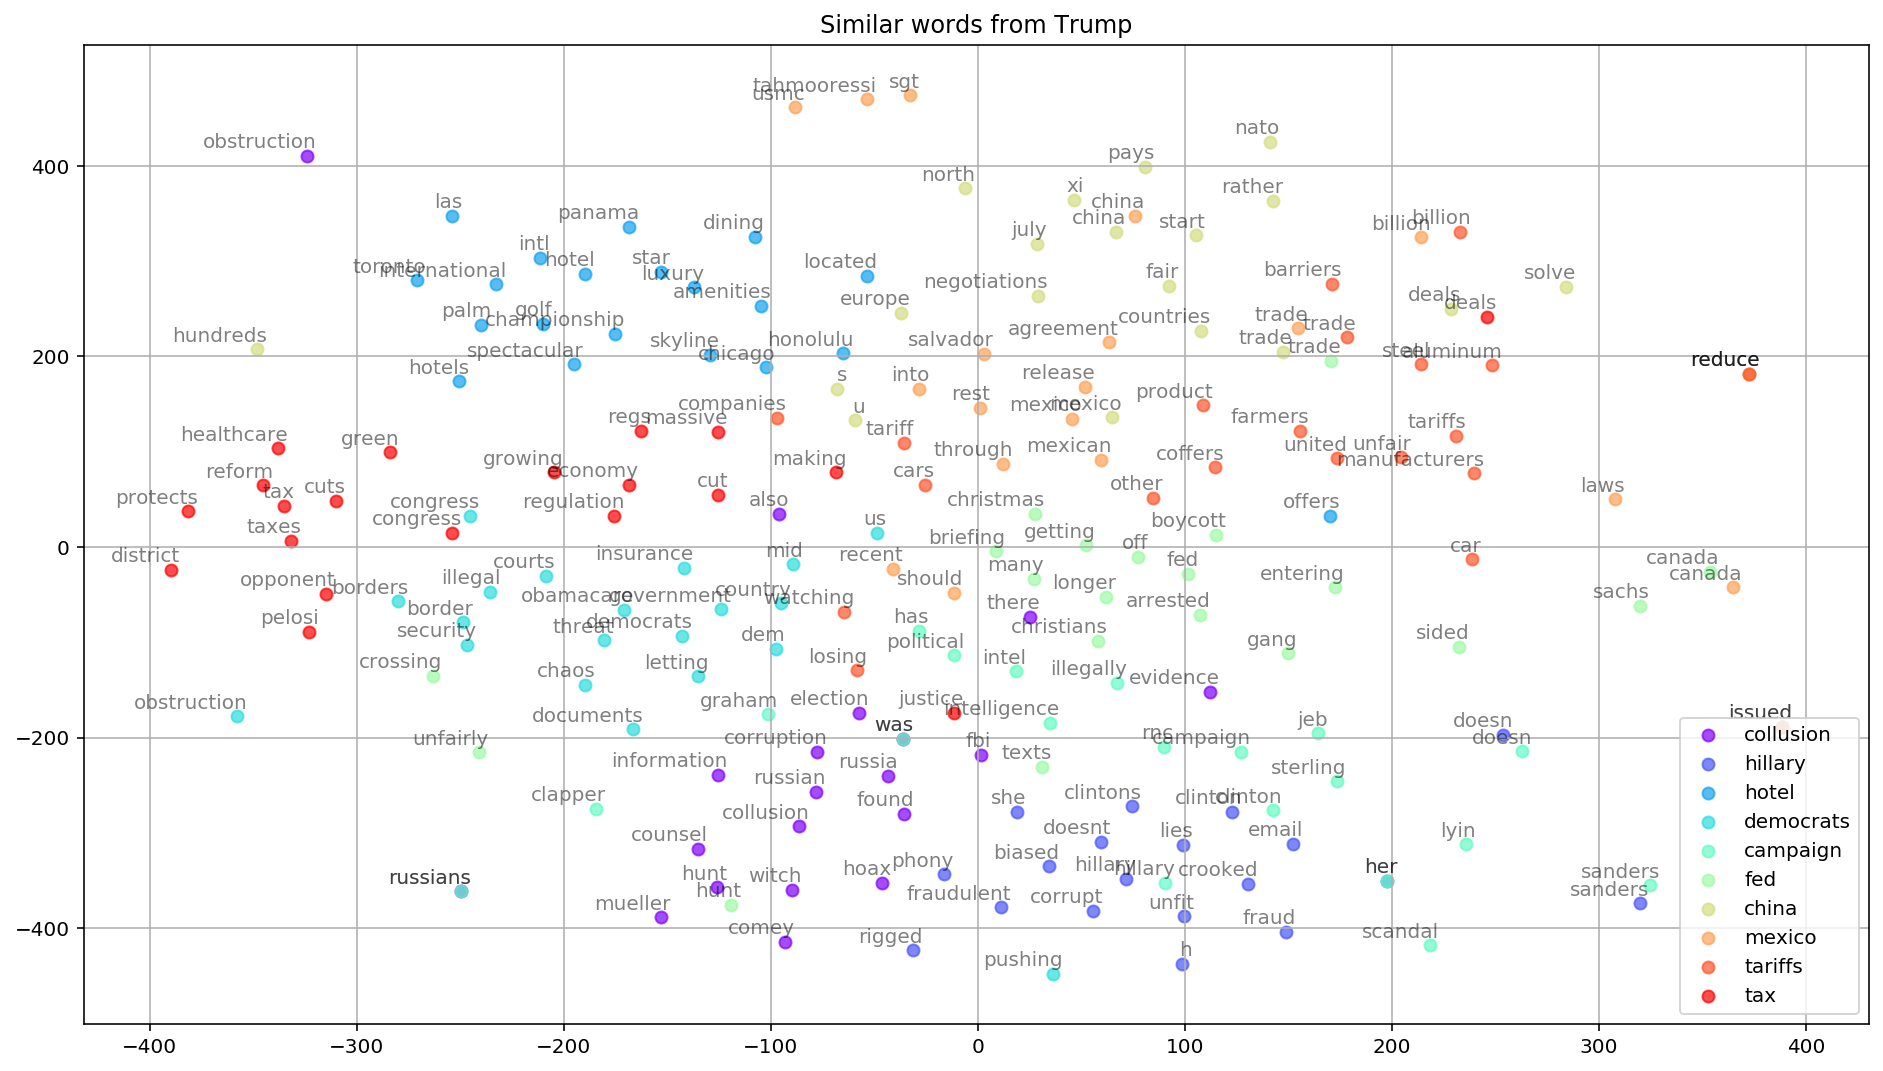

In [16]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Trump', keys, embeddings_en_2d, word_clusters, 0.7,
                        'results/similar_words_1901.png')


In [17]:
torch.save(model,'models/trump_rnn_1901.net')